In [1]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 1.03MB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 4.05MB/s]


100%|██████████| 98.1M/98.1M [00:01<00:00, 62.9MB/s]


100%|██████████| 90.2M/90.2M [00:01<00:00, 73.4MB/s]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_gallery(images, titles=None, num_cols=3, figsize=(10, 10)):
    # Ensure images are in the correct format for display
    images = images.numpy()  # Convert tensor to NumPy array

    num_images = images.shape[0]
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot each image individually
            ax.imshow(images[i])  # Display each image
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=10)
        else:
            ax.axis("off")  # Turn off axis if there are more subplots than images

    plt.tight_layout()
    plt.show()


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import KFold
import numpy as np

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5

# Load the entire dataset without splitting (for manual splitting later)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,  # Load one image at a time to avoid automatic batching
    label_mode='int'
)

# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
for image, label in dataset:
    images.append(image)
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)

# Define KFold cross-validator
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []

for train_index, val_index in kf.split(images):
    print(f"\nTraining fold {fold_no}...")

    # Split images and labels into training and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert them back to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE) / 255.0, y))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, IMAGE_SIZE) / 255.0, y))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    # Define the model using Functional API
    base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5", trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        metrics=["accuracy"]
    )

    # Train the model on this fold
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

    # Record validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")

    fold_no += 1

# Calculate and print the average validation accuracy across all folds
average_val_accuracy = np.mean(val_accuracies)
print(f"\nAverage validation accuracy across {NUM_FOLDS} folds: {average_val_accuracy}")


Found 32 files belonging to 4 classes.

Training fold 1...


ValueError: Exception encountered when calling layer 'keras_layer_1' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_1' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_362>
  • training=None

In [18]:
import tensorflow as tf
from tensorflow import keras

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE



# Load the training and validation datasets with a split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",     # Specify this subset as training
    seed=42,               # Random seed for reproducibility
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    validation_split=0.2,  # Reserve 20% for validation
    subset="validation",   # Specify this subset as validation
    seed=42,               # Same seed to ensure matching split
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)



# Get the number of classes from the training dataset
num_classes = len(train_dataset.class_names)
print("Classes found:", train_dataset.class_names)  # Optional: To verify class names

# Define resizing layer
resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)

def preprocess_inputs(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize if not already done
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Preprocess, shuffle, and batch the dataset
# Preprocess, shuffle, but do not batch again
train_dataset = train_dataset.map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(10 * BATCH_SIZE, reshuffle_each_iteration=True)



Found 32 files belonging to 4 classes.
Using 26 files for training.
Found 32 files belonging to 4 classes.
Using 6 files for validation.
Classes found: ['KO', 'OK', 'RzKO', 'RzOK']


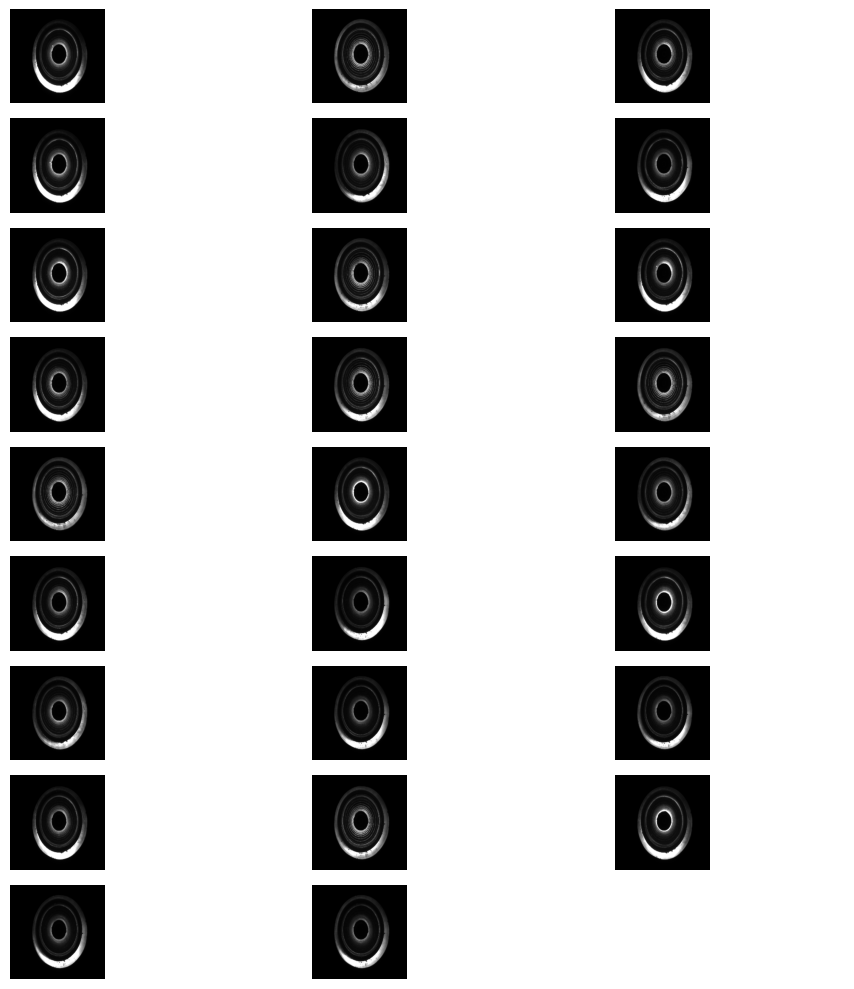

In [8]:
images = next(iter(train_dataset.take(1)))[0]
plot_image_gallery(images)

In [19]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_v2_50_imagenet", num_classes=4
)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

In [20]:
# model.fit(train_dataset , epochs=5)
model.fit(train_dataset, epochs=5, validation_data=val_dataset)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 76s 76s/step - accuracy: 0.3077 - loss: 4.7691 - val_accuracy: 0.3333 - val_loss: 6.1659
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 63s 63s/step - accuracy: 0.2692 - loss: 7.6661 - val_accuracy: 0.1667 - val_loss: 13.4317
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.2692 - loss: 11.9064 - val_accuracy: 0.1667 - val_loss: 3.1168
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - accuracy: 0.2692 - loss: 4.8881 - val_accuracy: 0.1667 - val_loss: 10.7454
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 44s 44s/step - accuracy: 0.2692 - loss: 4.5630 - val_accuracy: 0.1667 - val_loss: 13.4317


In [21]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"\nValidation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 13.4317

Validation Loss: 13.431746482849121
Validation Accuracy: 0.1666666716337204


In [29]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import KFold
import numpy as np

# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5

# Load the entire dataset without validation split (for manual cross-validation splitting later)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/praeciso/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,  # Load one image at a time to avoid automatic batching
    label_mode='int'
)

# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
for image, label in dataset:
    images.append(image[0])  # Remove the extra batch dimension here
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)

# Define KFold cross-validator
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []

Found 32 files belonging to 4 classes.


In [30]:


for train_index, val_index in kf.split(images):
    print(f"\nTraining fold {fold_no}...")

    # Split images and labels into training and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert them back to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize without resizing
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize without resizing
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    # Define the model using the Functional API
    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)  # This will keep the Keras tensor symbolic
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        metrics=["accuracy"]
    )
    model.build((None, 224, 224, 3))

    # Train the model on this fold
    history = model.fit(train_dataset,  epochs=5 ,validation_data=val_dataset)

    # Record validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    val_accuracies.append(val_accuracy)
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")

    fold_no += 1

# Calculate and print the average validation accuracy across all folds
average_val_accuracy = np.mean(val_accuracies)
print(f"\nAverage validation accuracy across {NUM_FOLDS} folds: {average_val_accuracy}")



Training fold 1...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step - accuracy: 0.2800 - loss: 1.3759 - val_accuracy: 0.4286 - val_loss: 1.3504
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - accuracy: 0.2800 - loss: 1.4144 - val_accuracy: 0.4286 - val_loss: 1.3288
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 0.2000 - loss: 1.4226 - val_accuracy: 0.4286 - val_loss: 1.3285
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.2800 - loss: 1.4156 - val_accuracy: 0.4286 - val_loss: 1.3344
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.2400 - loss: 1.4005 - val_accuracy: 0.5714 - val_loss: 1.3477
Fold 1 - Validation Accuracy: 0.5714285969734192

Training fold 2...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 62s 62s/step - accuracy: 0.1600 - loss: 1.3921 - val_accuracy: 0.2857 - val_loss: 1.3964
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 59s 59s/step - accuracy: 0.4400 - loss: 1.3667 - val_accuracy: 0.2857 - val_loss: 1.3654
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving RzKO16_02.bmp to RzKO16_02.bmp


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Get the file name of the uploaded image
file_name = list(uploaded.keys())[0]

# Load the image, resize to 224x224, and preprocess
image = tf.keras.preprocessing.image.load_img(file_name, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)  # Convert to array
image = image / 255.0  # Normalize to [0, 1] range
image = np.expand_dims(image, axis=0)  # Add batch dimension, making shape (1, 224, 224, 3)

# Predict using the model
predictions = model.predict(image)

# Map prediction indices to class labels
classes = {0: "KO", 1: "OK", 2: "RzKO", 3: "RzOK"}
top_class_index = predictions[0].argmax()  # Get the index of the highest probability
print("Top class is:", classes[top_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Top class is: KO


In [ ]:
# Map the output indices to your class names
classes = {0: "KO", 1: "OK", 2: "RzKO", 3: "RzOK"}

# Assuming `image` is a preprocessed image ready for prediction
predictions = model.predict(image)  # If `image` is a batch, ensure it's of shape (1, 224, 224, 3)

# Print the top predicted class
top_class_index = predictions[0].argmax()  # Get the index of the highest prediction score
print("Top class is:", classes[top_class_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Top class is: KO
